In [1]:
import baostock as bs
import pandas as pd

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取历史K线数据 ####
# 详细指标参数，参见“历史行情指标参数”章节
code = "sh.600183"
rs = bs.query_history_k_data_plus(code,
    "time,open,high,low,close,volume,amount",
    start_date='2020-01-01', end_date='2030-12-31', 
    frequency="5", adjustflag="2") #frequency="d"取日k线，adjustflag="2" #复权类型:1-后复权，2-前复权，3-不复权
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### join result ####
data_list = []
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

#### logout system ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success


KeyboardInterrupt: 

In [ ]:
for col in rs.fields:
    if col == 'time':
        result[col] = pd.to_datetime(result[col],format='%Y%m%d%H%M%S%f')
    else:
        result[col] = pd.to_numeric(result[col])
result.index = result['time']
result.index.name = 'time_index'

: 

In [ ]:
result.describe()

,time,open,high,low,close,volume,amount
count,66192,66192.000000,66192.000000,66192.000000,66192.000000,6.619200e+04,6.619200e+04
mean,2022-11-07 16:17:40.442349312,20.377803,20.422825,20.333897,20.378366,5.490042e+05,1.342622e+07
min,2020-01-02 09:35:00,11.754377,11.782209,11.726545,11.754377,0.000000e+00,0.000000e+00
25%,2021-06-07 14:03:45,15.549568,15.585914,15.520879,15.549568,2.098000e+05,3.946414e+06
50%,2022-11-08 12:17:30,19.973725,20.009488,19.938729,19.976192,3.656000e+05,7.773664e+06
75%,2024-04-11 10:31:15,23.401245,23.459053,23.342176,23.403696,6.484000e+05,1.558785e+07
max,2025-09-08 15:00:00,54.930000,55.070000,54.840000,54.920000,3.221398e+07,8.462223e+08
std,NaN,6.030630,6.055016,6.007428,6.031621,6.761372e+05,1.961572e+07


: 

In [ ]:
class Trading_Simulator:
    def __init__(self, initial_cash=30000.0):
        self.current_cash = initial_cash
        self.current_share = 0.0
        self.freze_share = 0.0
        self.commission = 1.1/1e5
        self.tax = 5/1e5
        self.history = []

    def buy(self, price, number=100):
        if self.current_cash < price*number*(1+self.commission):
            # print("Error: Not enough cash to buy")
            number = int(self.current_cash / (price*(1+self.commission)) / 100) * 100
        self.current_cash -= price*number*(1+self.commission)
        self.freze_share += number
        history_entry = {'price': price, 'number': number}
        self.history.append(history_entry)

    def sell(self, price, number=100):
        if number > self.current_share:
            # print("Error: Not enough shares to sell")
            number = self.current_share
        self.current_cash += price*number*(1-self.commission-self.tax)
        self.current_share -= number
        history_entry = {'price': price, 'sell_number': -number}
        self.history.append(history_entry)

    def settle(self):
        self.current_share += self.freze_share
        self.freze_share = 0.0

class Recorder:
    def __init__(self):
        self.max_value = -float('inf')
        self.min_value = float('inf')
        self.values = []

    def reset(self):
        self.max_value = -float('inf')
        self.min_value = float('inf')
        self.values = []

    def record(self, value):
        self.values.append(value)
        if value > self.max_value:
            self.max_value = value
        if value < self.min_value:
            self.min_value = value

    def __call__(self, value):
        return self.record(value)


: 

In [ ]:
ts = Trading_Simulator(3e4)
rec = Recorder()
current_date = None
alls = []
for index, row in result.iterrows():
    bs_prices = []
    if current_date != row['time'].date():
        alls.append([current_date, ts.current_cash+(ts.current_share+ts.freze_share)*rec.values[-1] if rec.values else 0])
        current_date = row['time'].date()
        # New trading day, settle previous trades
        ts.settle()
        rec.reset()
        # print("#"*20)
        # print(f"Date: {current_date}, Cash: {ts.current_cash}, Shares: {ts.current_share}")
        rec(row['open'])
    rec(row['close'])
    if (row['close'] > rec.min_value * 1.01) and (row['close'] <= min(bs_prices) if bs_prices else float('inf')):
        # print(f"Buy at {row['close']}")
        number_to_buy = int((row['close'] - rec.min_value)/rec.min_value*100) * 100
        ts.buy(row['close'])
        bs_prices.append(row['close'])
    elif (row['close'] < rec.max_value * 0.99) and (row['close'] >= max(bs_prices) if bs_prices else -float('inf')):
        # print(f"Sell at {row['close']}")
        number_to_sell = int((rec.max_value - row['close'])/rec.max_value*100) * 100
        ts.sell(row['close'], number_to_sell)
        bs_prices.append(row['close'])
trade_df = pd.DataFrame(alls, columns=['date', 'total_value'])
trade_df.dropna(inplace=True)

print(f"Date: {current_date}, Cash: {ts.current_cash}, Shares: {ts.current_share+ts.freze_share}")
print(alls[-1])

Date: 2025-09-08, Cash: 1768.2590008550997, Shares: 2000.0
[datetime.date(2025, 9, 5), 96822.7477158551]


: 

In [ ]:
import short_signal_module as ssm
bdf = ssm.apply_t1_exits(ssm.generate_signals(result), capital=300, risk_fraction=0.015)
perf, trades = ssm.evaluate_performance(bdf, 300)
print(perf)

d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recross_up = recross_up.shift(1).fillna(False)  # 对齐当前根


{'max_drawdown': -0.3463737154861073, 'sharpe': -0.12220978131393709, 'total_return': -0.13367687507145032, 'num_trades': 53, 'win_rate': 0.4528301886792453, 'avg_win': 9.147091819301522, 'avg_loss': -8.952871247747302}


: 

In [ ]:
def optimize_params(vol_multiplier=1.8,
                    donchian_n=15,
                    atr_n=14,
                    rsi_n=14,
                    z_win=60,
                    atr_low=0.003,
                    atr_high=0.025,
                    max_hold_days=2,
                    sl_atr=1.2,
                    trail_init=2.0,
                    trail_atr=1.5,
                    dd_atr=2.5,
                    risk_fraction=0.015)->float:
    donchian_n = int(donchian_n)
    atr_n = int(atr_n)
    rsi_n = int(rsi_n)
    z_win = int(z_win)
    max_hold_days = int(max_hold_days)
    bdf = ssm.apply_t1_exits(ssm.generate_signals(result,
                                                 vol_multiplier=vol_multiplier,
                                                 donchian_n=donchian_n,
                                                 atr_n=atr_n,
                                                 rsi_n=rsi_n,
                                                 z_win=z_win,
                                                 atr_low=atr_low,
                                                 atr_high=atr_high),
                             capital=300, risk_fraction=risk_fraction,
                             max_hold_days=max_hold_days,
                             sl_atr=sl_atr,
                             trail_init=trail_init,
                             trail_atr=trail_atr,
                             dd_atr=dd_atr)
    perf, trades = ssm.evaluate_performance(bdf, 300)
    return perf['total_return']
from scipy.optimize import minimize
res = minimize(lambda x: -optimize_params(*x),
               x0=[1.8, 15, 14, 14, 60, 0.003, 0.025, 2, 1.2, 2.0, 1.5, 2.5, 0.015],
               bounds=[(1.0, 3.0), (1, None), (1, None), (1, None), (1, None),
                       (0.001, 0.01), (0.01, 0.05), (1, 5), (0.5, 3.0),
                       (1.0, 3.0), (1.0, 3.0), (1.0, 5.0), (0.005, 0.03)],
               method='Powell')
print("Optimized results:", res)
print("Optimized params:", res.x)

d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recross_up = recross_up.shift(1).fillna(False)  # 对齐当前根
d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recross_up = recross_up.shift(1).fillna(False)  # 对齐当前根
d:\Documents\GitHub\Fund\short_signal_module.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future beha

: 

In [ ]:
bdf

,time,open,high,low,close,volume,amount,EMA5,EMA20,RSI,...,atr_pct,signal,position,entry_price,exit_price,shares,pnl,holding_days,equity,trade_pnl
time_index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:35:00,2020-01-02 09:35:00,18.515957,18.541938,18.264805,18.273465,4635300,98585861.0,18.273465,18.273465,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:40:00,2020-01-02 09:40:00,18.264805,18.429352,18.212842,18.386050,2183878,46229939.0,18.274399,18.273699,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:45:00,2020-01-02 09:45:00,18.403371,18.455334,18.368730,18.386050,2074560,44118640.0,18.275326,18.273933,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:50:00,2020-01-02 09:50:00,18.377390,18.576579,18.377390,18.567919,3660608,78201338.0,18.277754,18.274545,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
2020-01-02 09:55:00,2020-01-02 09:55:00,18.559259,18.767108,18.550598,18.758448,4648233,100050318.0,18.281743,18.275552,NaN,...,0.000000,0,0,NaN,NaN,0,0.0,0,300.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-27 14:40:00,2025-08-27 14:40:00,48.700000,48.860000,48.500000,48.500000,842800,41012736.0,47.828105,43.624724,23.049645,...,0.005994,0,1,48.83,NaN,6,0.0,0,590.062439,0.0
2025-08-27 14:45:00,2025-08-27 14:45:00,48.510000,48.540000,48.400000,48.410000,707500,34306816.0,47.832934,43.634683,24.344569,...,0.005769,0,1,48.83,NaN,6,0.0,0,590.062439,0.0
2025-08-27 14:50:00,2025-08-27 14:50:00,48.400000,48.420000,48.320000,48.350000,870700,42106496.0,47.837225,43.644497,26.104418,...,0.005540,0,1,48.83,NaN,6,0.0,0,590.062439,0.0


: 

In [ ]:
bdf['_equity'] = bdf['equity']*100

: 

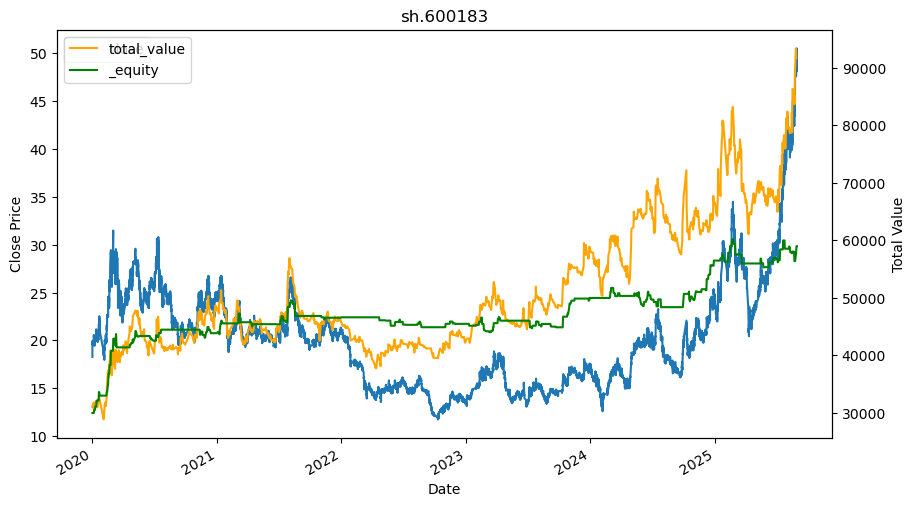

: 

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
twin_ax = ax.twinx()
result.plot(x='time', y='close', title=code, xlabel='Date', ylabel='Close Price', ax=ax)
trade_df.plot(x='date', y='total_value', ylabel='Total Value', ax=twin_ax, color='orange', sharex=True)
bdf.plot(x='time', y='_equity', ax=twin_ax, color='green', sharex=True)
plt.show()